## 1. Data preprocessing and visualiztion

In [2]:
from data_preprocessing import *
from data_preprocessing import plot_data
from sklearn.svm import SVR

In [3]:
token = "HPG"                       # name of the dataset
path = "../../Dataset/" + token + ".csv"
dataset = pd.read_csv(path)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(dataset['close']).reshape(-1,1))
scaled_data = scaled_data.reshape(scaled_data.shape[0])
print(scaled_data.shape)

(2087,)


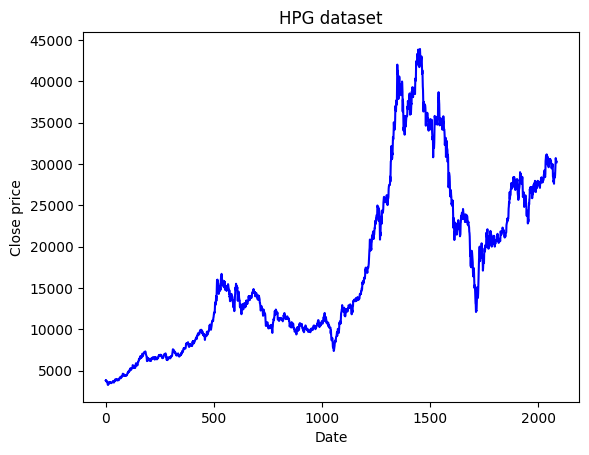

In [4]:
plt.plot(np.array(dataset['close']), color='blue')
plt.xlabel("Date")
plt.ylabel("Close price")
plt.title(token + " dataset")
plt.show()

In [5]:
# plot_data(datasets=np.array(dataset['close']), token=token)

## 2. Hyper-parameters optimization
There are 3 main factors that affect the efficiency of our SVR model:
1. **Training size:** the size of our train dataset
2. **Time-step:** the number of previous close prices (days) that to day close price depend on.
3. **Model hyper-parameters:** include **C**, **learning_rate**, **gamma**

### 2.1 Fix training size, time-step, change model hyper-parameters

We gonna fix the training size, time-step and evaluate our model efficiency on the **Model hyper-parameters**.

We will find the best model hyper-parameters by comparing accuracies which based on evaluating **r2_score** on **test set**.

This evaluation will show the effection of the change of **Model hyper-parameters** on our model efficiency

### 2.2 Fix training size, change time-step and model hyper-parameters

We gonna fix the training size and evaluate our model efficiency on the remain factors (**Time-step** and **Model hyper-parameters**).

For each value of time-step, we gonna find the best hyper-paramters for our SVR models, then we will compare the accuracy of each models based on evaluating **r2_score** on **test set** to find the best time-step for our current dataset.

This evaluation will show the effection of the change of **Time-step** and **Model hyper-parameters** on our model efficiency

Dataset: HPG
Training size: 80.0%
Train data:  (1669,)
Test data:  (418,)
For timestep = 7:
    r2_train=0.96971254833214
    r2_test=0.9100958943463449
Best params: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


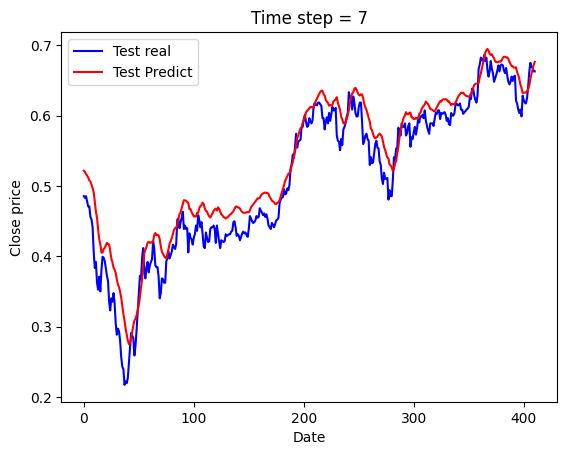

For timestep = 14:
    r2_train=0.9899132609277385
    r2_test=0.944644576508946
Best params: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


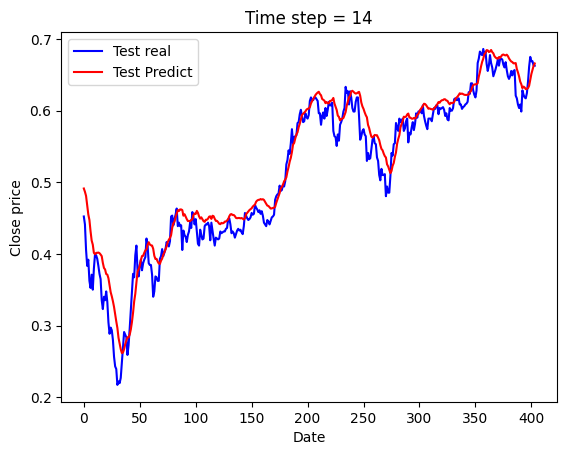

For timestep = 30:
    r2_train=0.9550449841255467
    r2_test=0.8968782155284379
Best params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


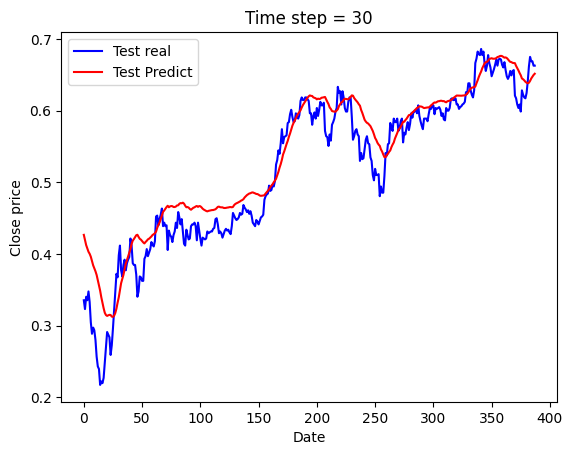

For timestep = 60:
    r2_train=0.9421263305157349
    r2_test=0.8877404092313703
Best params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


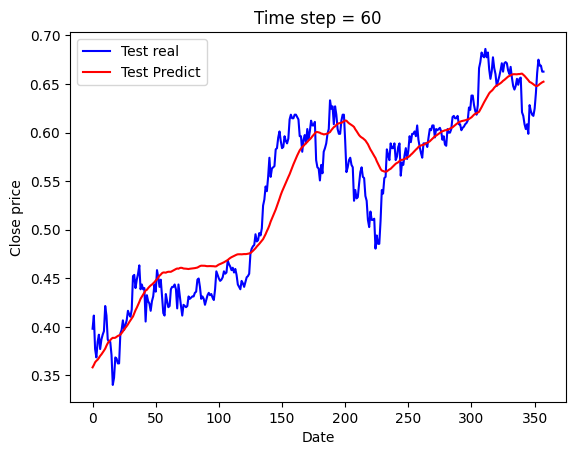

For timestep = 90:
    r2_train=0.9478740935361639
    r2_test=0.8518113716139446
Best params: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


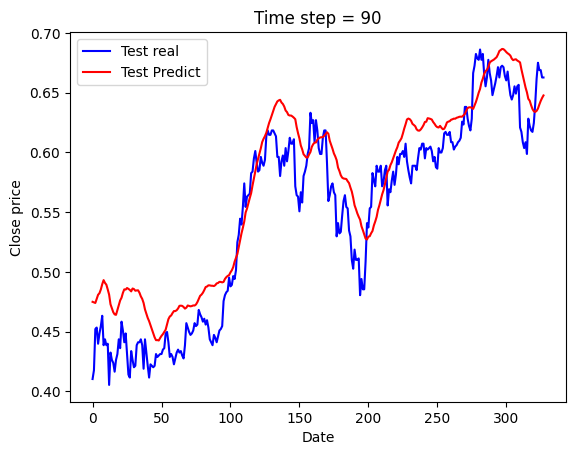

-------------------------
Best r2_score = 0.944644576508946 using: 
    parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
    time-step: 14


In [6]:
steps = [7, 14, 30, 60, 90]
lst_r2_train = []
lst_mae_train = []
lst_rmse_train = []
lst_mape_train = []

lst_mae_test = []
lst_rmse_test = []
lst_r2_test = []
lst_mape_test = []

train_size = 0.8

print(f"Dataset: {token}")
print(f"Training size: {train_size * 100}%")
data_for_train, data_for_test = scaled_data[: int(len(scaled_data) * train_size)], scaled_data[int(len(scaled_data) * train_size): ]
print("Train data: ", data_for_train.shape)
print("Test data: ", data_for_test.shape)
params_best = {}
best_r2_score = -100
best_step = 0
for step in steps:
    # Train test generate
    X_train, Y_train = data_generator(data_for_train, step)
    X_test, Y_test = data_generator(data_for_test, step)
    Y_train = Y_train.reshape(Y_train.shape[0])
    Y_test = Y_test.reshape(Y_test.shape[0])
    X, y = data_generator(scaled_data, step)
    # Fine-tuning hyper-parameters:
    ft_svr = SVR()
    C = [0.001, 0.1 ,1]
    gamma = [0.0001, 0.001, 0.01, 0.1]
    kernel = ['rbf', 'poly', 'linear']
    params = dict(C=C, gamma=gamma, kernel=kernel)
    tscv = TimeSeriesSplit(n_splits=10)

    grid_search = GridSearchCV(ft_svr, params, n_jobs=-1, cv=tscv,
                                    scoring='r2', verbose=0,
                                    return_train_score=True)
    grid_result = grid_search.fit(X_train, Y_train)
    best_params = grid_result.best_params_
    ft_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], 
    gamma=best_params['gamma'])
    ft_svr.fit(X_train, Y_train)
    y_pred = ft_svr.predict(X_test)

    # Evaluate train set
    y_train_pred = ft_svr.predict(X_train)
    r2_train = r2_score(Y_train, y_train_pred)
    rmse_train = mean_squared_error(Y_train, y_train_pred)
    mae_train = mean_absolute_error(Y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(Y_train, y_train_pred)

    lst_r2_train.append(r2_train)
    lst_mae_train.append(mae_train)
    lst_rmse_train.append(rmse_train)
    lst_mape_train.append(mape_train)

    # Evaluate test set
    r2_test = r2_score(Y_test, y_pred)
    rmse_test = mean_squared_error(Y_test, y_pred)
    mae_test = mean_absolute_error(Y_test, y_pred)
    mape_test = mean_absolute_percentage_error(Y_test, y_pred)

    lst_mae_test.append(mae_test)
    lst_rmse_test.append(rmse_test)
    lst_r2_test.append(r2_test)
    lst_mape_test.append(mape_test)

    if r2_test > best_r2_score:
        best_r2_score = r2_test
        params_best = best_params
        best_step = step

    print(f"For timestep = {step}:")
    print(f"    r2_train={r2_train}")
    print(f"    r2_test={r2_test}")
    # print(f"    mape_train={mape_train}")
    # print(f"    mape_test={mape_test}")

    print(f"Best params: {best_params}")

    plt.plot(Y_test, color = 'blue', label = 'Test real')
    plt.plot(y_pred, color='red', label = 'Test Predict')
    plt.title(f"Time step = {step}")
    plt.xlabel("Date")
    plt.ylabel("Close price")
    plt.legend()
    plt.show()

print("-------------------------")
print(f"Best r2_score = {best_r2_score} using: ")
print(f"    parameters: {params_best}")
print(f"    time-step: {best_step}")

#### Evaluate on different metrics:

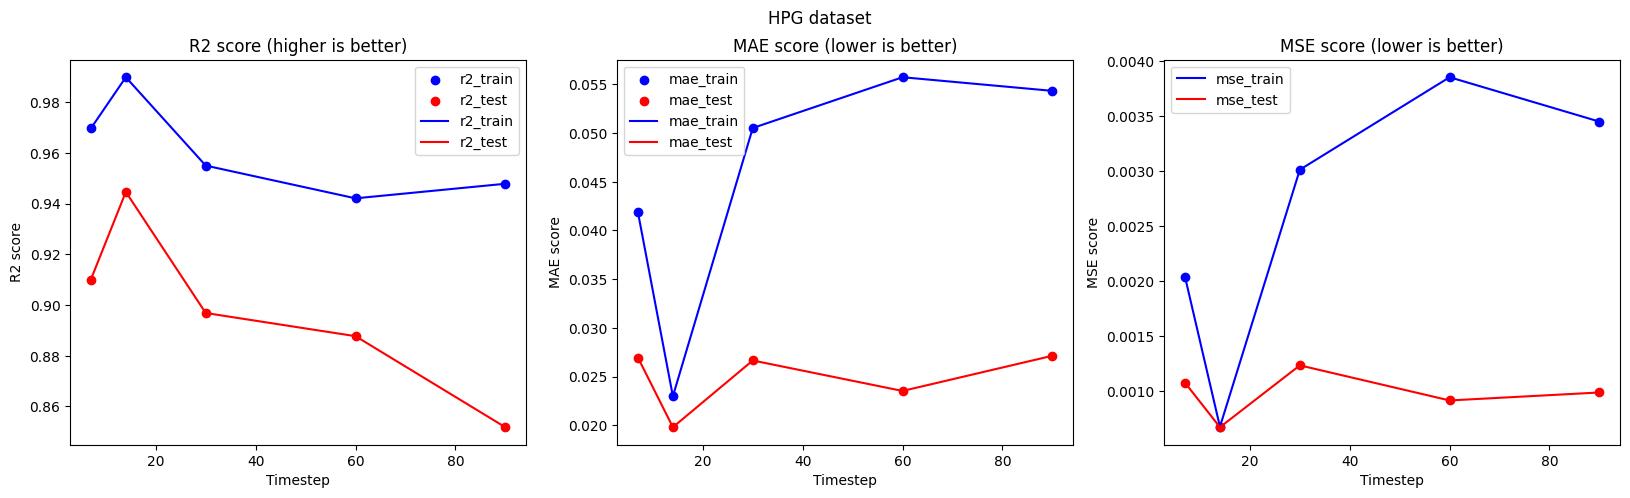

In [7]:
# R2 score
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(steps, lst_r2_train, color = 'blue', label = 'r2_train')
plt.scatter(steps, lst_r2_test, color = 'red', label = 'r2_test')
plt.plot(steps, lst_r2_train, color = 'blue', label = 'r2_train')
plt.plot(steps, lst_r2_test, color = 'red', label = 'r2_test')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("R2 score")
plt.title("R2 score (higher is better)")
# plt.show()

# MAE score
plt.subplot(1,3,2)
plt.scatter(steps, lst_mae_train, color = 'blue', label = 'mae_train')
plt.scatter(steps, lst_mae_test, color = 'red', label = 'mae_test')
plt.plot(steps, lst_mae_train, color = 'blue', label = 'mae_train')
plt.plot(steps, lst_mae_test, color = 'red', label = 'mae_test')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("MAE score")
plt.title("MAE score (lower is better)")
# plt.show()

# MSE score
plt.subplot(1,3,3)
plt.scatter(steps, lst_rmse_train, color = 'blue')
plt.scatter(steps, lst_rmse_test, color = 'red')
plt.plot(steps, lst_rmse_train, color = 'blue', label = 'mse_train')
plt.plot(steps, lst_rmse_test, color = 'red', label = 'mse_test')
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("MSE score")
plt.title("MSE score (lower is better)")
plt.suptitle(token + " dataset")
plt.show()

### 2.3. Change training size, time-step and model hyper-parameters

We gonna change all 3 factors that have effect on our model efficiency

For each value of training size, we gonna find the best time-step and best model hyper-parameters. Then we will compare the models accuracy based on evaluating **r2_score** on **test set** to find best training size for our current dataset.

This evaluation will show the effection of the change of **Training size**, **Time-step** and **Model hyper-parameters** on our model efficiency

In [8]:
steps = [7, 14, 30, 60, 90]

train_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

best_test_r2_score_per_trainsize = []
best_train_r2_score_per_trainsize = []

# Optimization hyper-parameters
opt_hyper_params = {
    "time-step": 0,
    "r2_score": -100,
    "parameters": {},
    "train_size": 0
}

for train_size in train_sizes:
    print("------------------------")   
    print(f"For training size: {train_size * 100}%")
    data_for_train, data_for_test = scaled_data[: int(len(scaled_data) * train_size)], scaled_data[int(len(scaled_data) * train_size): ]
    print("Train data: ", data_for_train.shape)
    print("Test data: ", data_for_test.shape)
    
    param = {}
    best_step = 0
    max_r2_score_test = -100
    r2_score_train = -100

    for step in steps:
        # Train test generate
        X_train, Y_train = data_generator(data_for_train, step)
        X_test, Y_test = data_generator(data_for_test, step)
        Y_train = Y_train.reshape(Y_train.shape[0])
        Y_test = Y_test.reshape(Y_test.shape[0])
        X, y = data_generator(scaled_data, step)
        
        # Fine-tuning hyper-parameters:
        ft_svr = SVR()
        C = [0.001, 0.1 ,1]
        gamma = [0.0001, 0.001, 0.01, 0.1]
        kernel = ['rbf', 'poly', 'linear']
        params = dict(C=C, gamma=gamma, kernel=kernel)
        tscv = TimeSeriesSplit(n_splits=10)

        grid_search = GridSearchCV(ft_svr, params, n_jobs=-1, cv=tscv,
                                  scoring='r2', verbose=0,
                                   return_train_score=True)
        grid_result = grid_search.fit(X_train, Y_train)
        best_params = grid_result.best_params_
        ft_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], 
                    gamma=best_params['gamma'])
        ft_svr.fit(X_train, Y_train)
        y_pred = ft_svr.predict(X_test)
        
        # Evaluate train set
        y_train_pred = ft_svr.predict(X_train)
        r2_train = r2_score(Y_train, y_train_pred)
        rmse_train = mean_squared_error(Y_train, y_train_pred)
        mae_train = mean_absolute_error(Y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(Y_train, y_train_pred)

        # Evaluate test set
        r2_test = r2_score(Y_test, y_pred)
        rmse_test = mean_squared_error(Y_test, y_pred)
        mae_test = mean_absolute_error(Y_test, y_pred)
        mape_test = mean_absolute_percentage_error(Y_test, y_pred)
        if r2_test > max_r2_score_test:
            max_r2_score_test = r2_test
            best_step = step
            param = best_params
            r2_score_train = r2_train

    best_test_r2_score_per_trainsize.append(max_r2_score_test)
    best_train_r2_score_per_trainsize.append(r2_score_train)
    print(f"Best r2_score = {max_r2_score_test} using: ")
    print(f"   time_step = {best_step}")
    print(f"   params = {param}")

    if max_r2_score_test > opt_hyper_params["r2_score"]:
        opt_hyper_params["r2_score"] = max_r2_score_test
        opt_hyper_params["parameters"] = param
        opt_hyper_params["time-step"] = best_step
        opt_hyper_params["train_size"] = train_size


------------------------
For training size: 50.0%
Train data:  (1043,)
Test data:  (1044,)
Best r2_score = -0.21908007676289798 using: 
   time_step = 14
   params = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
------------------------
For training size: 60.0%
Train data:  (1252,)
Test data:  (835,)
Best r2_score = 0.4286832732098872 using: 
   time_step = 30
   params = {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
------------------------
For training size: 70.0%
Train data:  (1460,)
Test data:  (627,)
Best r2_score = 0.9314197573841647 using: 
   time_step = 14
   params = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
------------------------
For training size: 80.0%
Train data:  (1669,)
Test data:  (418,)
Best r2_score = 0.944644576508946 using: 
   time_step = 14
   params = {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
------------------------
For training size: 90.0%
Train data:  (1878,)
Test data:  (209,)
Best r2_score = 0.7386099374798691 using: 
   time_step = 30
   params

In [9]:
print("------------------------")
print("Best r2_score = ", opt_hyper_params["r2_score"], " using:")
print(f"    training size = ", opt_hyper_params["train_size"])
print(f"    time-step = ", opt_hyper_params["time-step"])
print(f"    parameters = ", opt_hyper_params["parameters"])

------------------------
Best r2_score =  0.944644576508946  using:
    training size =  0.8
    time-step =  14
    parameters =  {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


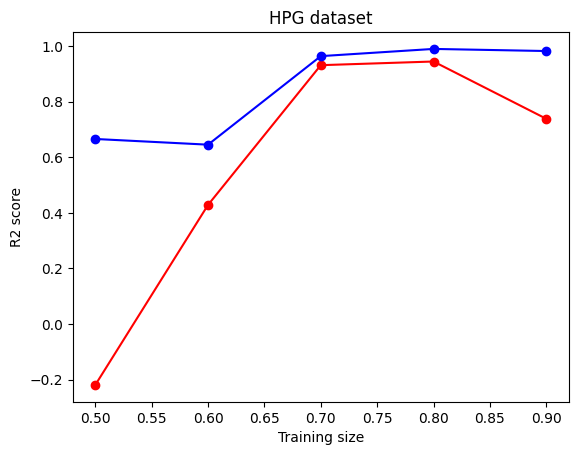

In [10]:
plt.plot(train_sizes, best_test_r2_score_per_trainsize, color='red', label = ' Test')
plt.scatter(train_sizes, best_test_r2_score_per_trainsize, color='red')
plt.plot(train_sizes, best_train_r2_score_per_trainsize, color='blue', label = 'Train')
plt.scatter(train_sizes, best_train_r2_score_per_trainsize, color='blue')
plt.xlabel("Training size")
plt.ylabel("R2 score")
plt.title(token + " dataset")
plt.show()

## 3. Evaluation
Now, we have our optimized hyper-parameters.

We will retrain our SVR model with these hyper-parameter then evaluate on entire dataset.

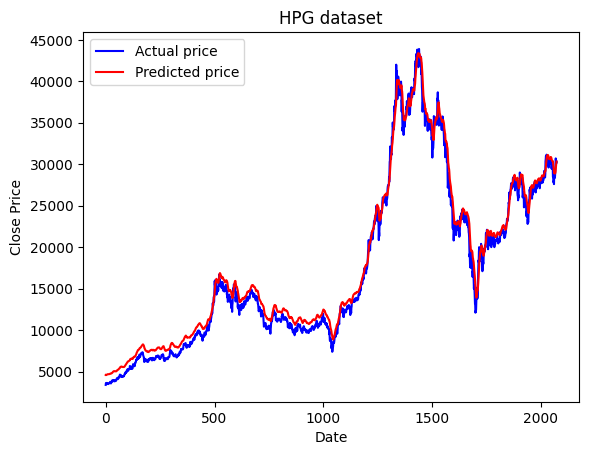

In [11]:
data_for_train, data_for_test = scaled_data[: int(len(scaled_data) * opt_hyper_params["train_size"])], scaled_data[int(len(scaled_data) * opt_hyper_params["train_size"]): ]
X_train, Y_train = data_generator(data_for_train, opt_hyper_params["time-step"])
X_test, Y_test = data_generator(data_for_test, opt_hyper_params["time-step"])
Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])
X, y = data_generator(scaled_data, opt_hyper_params["time-step"])

opt_svr = SVR(C = opt_hyper_params["parameters"]['C'], 
              kernel = opt_hyper_params["parameters"]['kernel'],
              gamma = opt_hyper_params["parameters"]['gamma'])

opt_svr.fit(X_train, Y_train)
y_all_pred = opt_svr.predict(X).reshape(-1, 1)
y_all_pred = scaler.inverse_transform(y_all_pred)
y = scaler.inverse_transform(y.reshape(-1, 1))

plt.plot(y, color='blue', label = 'Actual price')
plt.plot(y_all_pred, color = 'red', label = 'Predicted price')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.title(token + " dataset")
plt.show()